# Space junk simulation

In [1]:
import os
import matplotlib.pyplot as plt
import subprocess
import json
import math
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

Основной используемый объект - бинарник gpu_spacejunk.exe. Программа принимает на вход единственный аргумент - путь к конфигурационному файлу, который содержит описание модели и пути для выходных данных. Подробное описание конфигурационного файла есть на github.

Напишем функцию, которая принимает на вход все необходимую информацию о модели и возвращает требуемые траектории и опасные сближения, запуская нужный бинарник.

### TL;DR
Запускаем $run\_simulations$:

$time$ - время начала моделирования, с

$dt$ - интервал, через который считается новая позиция, с

$steps$ - кол-во итераций

$maxSteps$ - максимальное кол-во шагов, которое будет за 1 раз промоделировано на GPU

$objects$ - массив объектов. Объект - массив из 7 чисел: x, y, z, vx, vy, vz, size - начальное положение, скорость и размер

$forces$ - массив строк-идентификаторов сил (см. добавление сил на github)

$log\_trajectories$ - массив из индексов объектов, для которых надо запомнить траекторию

$collision\_options$ - опция для поиска сближений. Если "disabled" - не ищем коллизии, если "slow" - то ищем за квадрат, иначе - ищем быстрым алгоритмом

Возвращает пару:

$trajectories$ - словарь {индекс объекта : массив из его траекторий}

$collisions$ - массив троек: (время, id объекта, id объекта)



Запускаем $draw\_trajectories$ - передаем $trajectories$ из $run\_simulations$. Получаем картинку.

In [2]:
def run_simulation(time, dt, steps, max_steps, objects, forces, log_trajectories, collision_option=""):
    with open("./cfg.txt", "w") as f:
        f.write(' '.join([str(x) for x in [time, dt, max_steps, steps]]) + '\n')
        f.write(str(len(objects)) + '\n')
        for obj in objects:
            f.write(' '.join([str(x) for x in obj]) + '\n')
        f.write(str(len(log_trajectories)) + '\n')
        f.write(' '.join([str(x) for x in log_trajectories]) + '\n')
        f.write(str(len(forces)) + '\n')
        f.write(' '.join(forces) + '\n')
        f.write("trajectories.txt\n")
        f.write("collisions.txt\n")
        f.write("\n")
        
    FNULL = open(os.devnull, 'w')
    args = "../bin/gpu_spacejunk.exe ./cfg.txt"
    res = subprocess.call(args, stdout=FNULL, stderr=FNULL, shell=False)
    if res:
        return None
    
    trajectories = {}
    with open("trajectories.txt") as tr:
        if tr:
            line = tr.readline()
            cur_id = None
            while (line):
                coords = line.split()
                if len(coords) == 1:
                    cur_id = int(coords[0])
                    trajectories[cur_id] = []
                else:
                    trajectories[cur_id].append([float(x) for x in coords])
                line = tr.readline()
    
    collisions = []
    with open("collisions.txt") as coll:
        if coll:
            line = coll.readline()
            while (line):
                collision = line.split()
                collisions.append((float(collisions[0]), int(collision[1]), int(collisions[2])))
                line = coll.readline()
    return trajectories, collisions

Попробуем запустить функцию на простейшем примере - единственный объект вращается по окружности в проскости $z=0$ на расстоянии $1.2R$ от центра Земли.

In [3]:
M = 5.972e24
R = 6.371e6
G = 6.67408e-11

res = run_simulation(0.0, 1.0, 10000, 100, [[0.0, 1.2 * R, 0.0, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0]], ['gravity'], [0])
print(len(res[0][0]))
for coords in res[0][0]:
    print(coords)

10000
[7220.397604382382, 7645196.59039965, 0.0, 7220.395457617271, -6.819200193012766, 0.0]
[14440.788768470149, 7645186.361601641, 0.0, 7220.385797176783, -13.638394303582336, 0.0]
[21661.16705197443, 7645169.313615098, 0.0, 7220.3696964522105, -20.457576249270936, 0.0]
[28881.526014617837, 7645145.446455225, 0.0, 7220.3471554579155, -27.27673994765165, 0.0]
[36101.85921614023, 7645114.760143313, 0.0, 7220.318174214003, -34.09587931631383, 0.0]
[43322.16021630443, 7645077.25470673, 0.0, 7220.282752746323, -40.91498827286853, 0.0]
[50542.42257490199, 7645032.930178932, 0.0, 7220.24089108647, -47.73406073495393, 0.0]
[57762.639851758926, 7644981.786599453, 0.0, 7220.192589271783, -54.553090620240766, 0.0]
[64982.80560674147, 7644923.824013911, 0.0, 7220.137847345344, -61.372071846437755, 0.0]
[72202.9133997618, 7644859.042474007, 0.0, 7220.076665355983, -68.190998331297, 0.0]
[79422.95679078382, 7644787.442037523, 0.0, 7220.00904335827, -75.00986399261944, 0.0]
[86642.92933982884, 7644

[7318226.629871066, -2211931.742582536, 0.0, -2089.0269750236016, -6911.59340264577, 0.0]
[7316134.339429576, -2218842.3484821077, 0.0, -2095.553596917054, -6909.617369168917, 0.0]
[7314035.523300281, -2225750.9752665097, 0.0, -2102.07834966378, -6907.635172600504, 0.0]
[7311930.183355237, -2232657.616773534, 0.0, -2108.6012274439713, -6905.646814708567, 0.0]
[7309818.321472322, -2239562.2668427434, 0.0, -2115.1222244394917, -6903.652297266639, 0.0]
[7307699.939535226, -2246464.919315477, 0.0, -2121.641334833883, -6901.651622053746, 0.0]
[7305575.039433459, -2253365.568034855, 0.0, -2128.158552812369, -6899.644790854408, 0.0]
[7303443.623062343, -2260264.2068457864, 0.0, -2134.673872561863, -6897.6318054586345, 0.0]
[7301305.692323015, -2267160.8295949716, 0.0, -2141.18728827097, -6895.612667661925, 0.0]
[7299161.249122418, -2274055.43013091, 0.0, -2147.698794129994, -6893.587379265267, 0.0]
[7297010.295373308, -2280948.0023039044, 0.0, -2154.208384330942, -6891.555942075133, 0.0]
[729

[-1062114.3061170578, -7571063.085243632, 0.0, -7150.381139796396, 1003.0985103755727, 0.0]
[-1069264.212512968, -7570056.610345551, 0.0, -7149.43058912103, 1009.8511361652415, 0.0]
[-1076413.1651696346, -7569043.383271551, 0.0, -7148.4736614506755, 1016.6028612096619, 0.0]
[-1083561.1577104887, -7568023.404925387, 0.0, -7147.510357638874, 1023.3536794865755, 0.0]
[-1090708.183759818, -7566996.67621684, 0.0, -7146.540678544851, 1030.1035849745329, 0.0]
[-1097854.2369427725, -7565963.198061707, 0.0, -7145.564625033522, 1036.8525716528989, 0.0]
[-1104999.3108853695, -7564922.9713818105, 0.0, -7144.582197975485, 1043.600633501858, 0.0]
[-1112143.3992144999, -7563875.997104987, 0.0, -7143.593398247023, 1050.3477645024195, 0.0]
[-1119286.4955579338, -7562822.276165094, 0.0, -7142.598226730106, 1057.0939586364227, 0.0]
[-1126428.5935443263, -7561761.809502008, 0.0, -7141.596684312385, 1063.839209886543, 0.0]
[-1133569.6868032226, -7560694.598061621, 0.0, -7140.5887718871945, 1070.58351223629

[-7644256.467970584, -120108.66699800265, 0.0, -113.43489514740486, 7219.507572572799, 0.0]
[-7644366.493669313, -112889.10693271016, 0.0, -106.61648595608419, 7219.61148475425, 0.0]
[-7644469.700910796, -105669.44617502546, 0.0, -99.79798166728855, 7219.708957342272, 0.0]
[-7644566.089602976, -98449.6911645859, 0.0, -92.97938836284042, 7219.799990249921, 0.0]
[-7644655.659659877, -91229.84834111296, 0.0, -86.16071212464168, 7219.884583396002, 0.0]
[-7644738.411001608, -84009.9241444064, 0.0, -79.34195903466816, 7219.962736705061, 0.0]
[-7644814.343554357, -76789.92501433857, 0.0, -72.5231351749643, 7220.034450107387, 0.0]
[-7644883.457250396, -69569.85739084869, 0.0, -65.70424662763759, 7220.099723539016, 0.0]
[-7644945.752028078, -62349.72771393701, 0.0, -58.885299474853255, 7220.158556941727, 0.0]
[-7645001.227831839, -55129.54242365919, 0.0, -52.0662997988288, 7220.210950263042, 0.0]
[-7645049.884612195, -47909.307960120466, 0.0, -45.24725368182857, 7220.256903456229, 0.0]
[-764509

[-1292332.642745045, 7535181.44310375, 0.0, 7116.493241315677, 1220.524892077304, 0.0]
[-1285215.5742081585, 7536398.607280025, 0.0, 7117.642774435673, 1213.8032795291301, 0.0]
[-1278097.3593123876, 7537609.049301921, 0.0, 7118.785958914093, 1207.0805843188712, 0.0]
[-1270978.0044068843, 7538812.768089775, 0.0, 7119.922793731261, 1200.3568124428919, 0.0]
[-1263857.515841817, 7540009.762569918, 0.0, 7121.0532778731695, 1193.6319698985171, 0.0]
[-1256735.899968366, 7541200.031674682, 0.0, 7122.177410331473, 1186.9060626840273, 0.0]
[-1249613.1631387162, 7542383.574342396, 0.0, 7123.295190103492, 1180.1790967986522, 0.0]
[-1242489.3117060536, 7543560.389517389, 0.0, 7124.406616192214, 1173.4510782425655, 0.0]
[-1235364.352024557, 7544730.476149991, 0.0, 7125.511687606292, 1166.7220130168803, 0.0]
[-1228238.2904493946, 7545893.833196534, 0.0, 7126.6104033600495, 1159.9919071236432, 0.0]
[-1221111.1333367173, 7547050.459619351, 0.0, 7127.7027624734765, 1153.260766565829, 0.0]
[-1213982.8870

[7245122.330326124, 2440755.100088849, 0.0, 2305.1358888492036, -6842.5511031932565, 0.0]
[7247424.23469827, 2433911.4614768066, 0.0, 2298.6725132428764, -6844.725103518295, 0.0]
[7249719.67466917, 2427065.651916883, 0.0, 2292.2070873161897, -6846.892998632978, 0.0]
[7252008.648191385, 2420217.6775152558, 0.0, 2285.739616836035, -6849.054786603631, 0.0]
[7254291.153223247, 2413367.5443800334, 0.0, 2279.270107571127, -6851.210465502031, 0.0]
[7256567.187728856, 2406515.2586212503, 0.0, 2272.7985652919992, -6853.360033405402, 0.0]
[7258836.749678084, 2399660.8263508603, 0.0, 2266.3249957709986, -6855.503488396417, 0.0]
[7261099.837046576, 2392804.253682732, 0.0, 2259.84940478228, -6857.640828563205, 0.0]
[7263356.447815752, 2385945.546732644, 0.0, 2253.3717981018017, -6859.772051999346, 0.0]
[7265606.579972808, 2379084.7116182777, 0.0, 2246.892181507319, -6861.897156803879, 0.0]
[7267850.231510721, 2372221.7544592125, 0.0, 2240.4105607783813, -6864.016141081296, 0.0]
[7270087.400428247, 

[3524183.8779337616, -6784483.107393751, 0.0, -6407.507044674555, -3328.3645440843725, 0.0]
[3517774.8001288404, -6787808.445704542, 0.0, -6410.647612395786, -3322.311583153547, 0.0]
[3511362.5846149805, -6791127.72957227, 0.0, -6413.7824620857455, -3316.2556588588495, 0.0]
[3504947.2371116118, -6794440.956036272, 0.0, -6416.911590948276, -3310.1967766019134, 0.0]
[3498528.763340957, -6797748.122141289, 0.0, -6420.034996192326, -3304.134941787009, 0.0]
[3492107.1690280284, -6801049.224937463, 0.0, -6423.152675031946, -3298.070159821042, 0.0]
[3485682.4599006213, -6804344.26148035, 0.0, -6426.264624686298, -3292.002436113545, 0.0]
[3479254.6416893094, -6807633.228830914, 0.0, -6429.370842379651, -3285.931776076676, 0.0]
[3472823.720127439, -6810916.124055532, 0.0, -6432.471325341388, -3279.8581851252115, 0.0]
[3466389.7009511255, -6814192.944225999, 0.0, -6435.566070806008, -3273.781668676542, 0.0]
[3459952.589899246, -6817463.686419526, 0.0, -6438.655076013126, -3267.7022321506674, 0.0

In [4]:
def draw_trajectories(trajectories):
    fig = pyplot.figure()
    ax = Axes3D(fig)
    for index, points in trajectories.items():
        x_coord = [i[0] for i in points]
        y_coord = [i[1] for i in points]
        z_coord = [i[2] for i in points]
        ax.scatter(x_coord, y_coord, z_coord)
    pyplot.show()

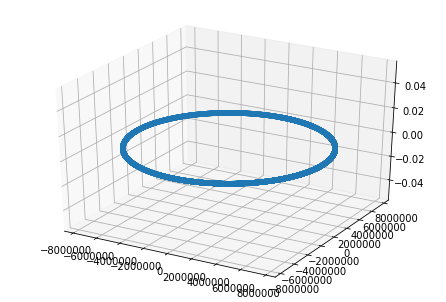

In [5]:
draw_trajectories(res[0])

# Тестирование

### Проверка корректности моделирования

Проверим, что в самом простом случае (вращение по окружности в плоскости $z=0$) выполненяются 2 инварианта: расстояние до центра постоянно и скорость постоянна.

In [6]:
M = 5.972e24
R = 6.371e6
G = 6.67408e-11

eps = 10 ** -1 
res = run_simulation(0.0, 1, 10000, 100, [[0.0, 1.2 * R, 0.0, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0]], ['gravity'], [0])
start = res[0][0][0]
V = start[3] ** 2 + start[4] ** 2 + start[5] ** 2
for i, coords in enumerate(res[0][0]):
    if abs((coords[0] ** 2 + coords[1] ** 2 + coords[2] ** 2) ** 0.5 - 1.2 * R) > eps:
        print("Test failed: R")
        print("Step " + str(i))
        print("Diff is " + str(abs((coords[0] ** 2 + coords[1] ** 2 + coords[2] ** 2) ** 0.5 - 1.2 * R)))
        break
    if abs((coords[3] ** 2 + coords[4] ** 2 + coords[5] ** 2) ** 0.5 - V ** 0.5) > eps:
        print("Test failed: V")
        print("Step " + str(i))
        print("Diff is " + str(abs((coords[3] ** 2 + coords[4] ** 2 + coords[5] ** 2) ** 0.5 - V ** 0.5)))
        break

Построим траектории нескольких объектов - ожидаем увидеть эллипсы.

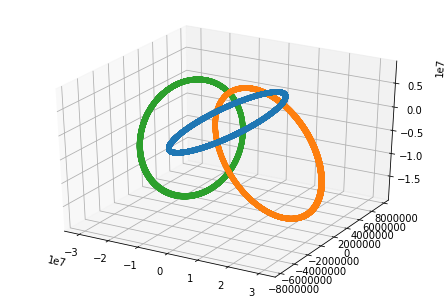

In [7]:
res = run_simulation(0.0, 100, 10000, 100, 
                     [
                         [0.0, 1.2 * R, 0.0, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0],
                         [1.2 * R, 0.0, 1.2 * R, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0],
                         [- 1.2 * R, 0.0, 1.2 * R, (G * M / (1.2 * R)) ** 0.5, 0.0, 0.0, 1.0]
                     ], 
                     ['gravity'],
                     [0, 1, 2])
draw_trajectories(res[0])

### Проверка корректности поиска сближений

### Оценка времени работы симуляции